# Predicción meteorológica por método Univariante y Unistep

![Modelo](images/Diagrama_univariable_unistep.png "Modelo univariable y unistep")

Para este problema, utilizaremos el data set preprocesado que obtuvimos en [01_LSTM_weather_forecasting.Procesamiento_datos.ipynb](01_LSTM_weather_forecasting.Procesamiento_datos.ipynb).

Queremos pode predecir la variable temperatura en la próxima hora teniendo en cuenta los valores de temperatura en las 24 horas previas.

## 0. Importamos librerías

In [1]:
# --- Bibliotecas estándar ---
import os
from datetime import datetime

# --- Bibliotecas de análisis de datos ---
import numpy as np
import pandas as pd

# --- Bibliotecas de visualización ---
import matplotlib.pyplot as plt

# --- Bibliotecas de aprendizaje automático ---
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

# --- PyTorch y submódulos ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

# --- Módulos personalizados ---
import helpers.helpers as helpers


## 1. Cargamos los datos previamente procesados 📥 📂

In [2]:
# Ruta al archivo preprocesado
file_path = "data/max_planck_weather_ts_preprocesado.csv"

# Verificar existencia del archivo preprocesado
if os.path.exists(file_path):
    # Cargar el archivo si existe
    df = pd.read_csv(file_path)
    print("Archivo preprocesado cargado correctamente.")
else:
    # Mostrar mensaje de error si no se encuentra el archivo
    raise FileNotFoundError("El archivo preprocesado 'max_planck_weather_ts_preprocesado.csv' no se encuentra en la carpeta 'data'. Por favor, verifica su existencia o realiza el preprocesamiento necesario.")
    
# Mostrar el DataFrame cargado
df

Archivo preprocesado cargado correctamente.


,datetime,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,2016-12-31 20:00:00,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00
70124,2016-12-31 21:00:00,1001.29,-3.09,269.98,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50
70125,2016-12-31 22:00:00,1000.70,-2.59,270.51,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15
70126,2016-12-31 23:00:00,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70


## 2. Pre-procesamiento
Dentro del pre-procesamiento de datos haremos:
1. Partición en train/val/test (80%, 10%, 10%)
2. Creación de las secuencias de datos
3. Normalización escalando los datos conforme a la variable/s

### 2.1. Partición del set en entrenamiento, validación y prueba

In [3]:
from helpers import train_val_test_split

tr, vl, ts = train_val_test_split(df['T (degC)'])
print(f'Tamaño data frame: {len(df)}')
print(f'Tamaño set de entrenamiento: {len(tr)}')
print(f'Tamaño set de validación: {len(vl)}')
print(f'Tamaño set de prueba: {len(ts)}')

Tamaño data frame: 70128
Tamaño set de entrenamiento: 56102
Tamaño set de validación: 7012
Tamaño set de prueba: 7014


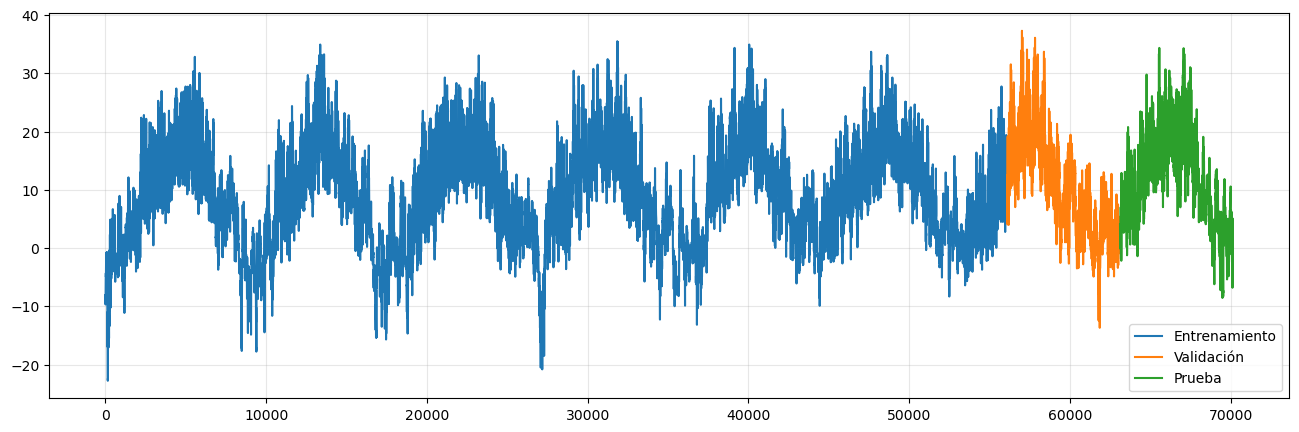

In [4]:
# Dibujamos los conjuntos
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(tr, label='Entrenamiento')
ax.plot(vl, label='Validación')
ax.plot(ts, label='Prueba')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

### 2.1 Creación de las secuencias de datos

El dato de entrada debe tener una dimensión (batches, longitud y variables).
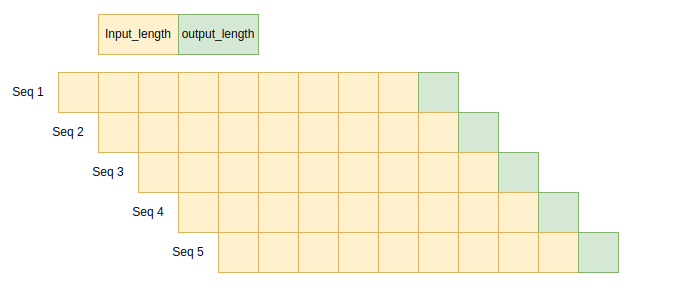

In [4]:
from helpers import create_dataset_supervised

# Creamos los dataset de entrenamiento, prueba y validación
INPUT_LENGTH = 24       # Ventana de entrada de 24 horas previas
OUTPUT_LENGTH = 1       # Ventana de salida de 1 hora posterior

x_tr, y_tr = create_dataset_supervised(tr.values, INPUT_LENGTH, OUTPUT_LENGTH, 0)
x_vl, y_vl = create_dataset_supervised(vl.values, INPUT_LENGTH, OUTPUT_LENGTH, 0)
x_ts, y_ts = create_dataset_supervised(ts.values, INPUT_LENGTH, OUTPUT_LENGTH, 0)

print('Tamaños de los conjuntos de datos (Seq x Input_length x Features) y de salida (Seq x Input_length x Features):')
print(f'Tamaño set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Tamaño set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Tamaño set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños de los conjuntos de datos (Seq x Input_length x Features) y de salida (Seq x Input_length x Features):
Tamaño set de entrenamiento - x_tr: (56077, 24, 1), y_tr: (56077, 1, 1)
Tamaño set de validación - x_vl: (6987, 24, 1), y_vl: (6987, 1, 1)
Tamaño set de prueba - x_ts: (6989, 24, 1), y_ts: (6989, 1, 1)


### 2.3 Normalización escalando los datos conforme a la variable/s

In [5]:
from helpers import scale_data

# Escalamos los datos
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts
}

data_s, scaler = scale_data(data_in)

# Extraemos los datos escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificamos los datos escalados
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')
print("-----------------------------------------------------")
print(f'Max x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento: -22.76/-13.67/-8.55
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-0.6972018654230512/-0.5266489007328448

Min y_tr/y_vl/y_ts sin escalamiento: -22.76/-13.67/-8.55
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-0.6972018654230512/-0.5266489007328448
-----------------------------------------------------
Max x_tr/x_vl/x_ts sin escalamiento: 35.48/37.28/34.34
Max x_tr/x_vl/x_ts con escalamiento: 0.9400399733510989/0.9999999999999998/0.9020652898067953

Max y_tr/y_vl/y_ts sin escalamiento: 35.48/37.28/34.34
Max y_tr/y_vl/y_ts con escalamiento: 0.9400399733510989/0.9999999999999998/0.9020652898067953


## 3. Creación del modelo

In [6]:
# Definir modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_dim)
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out.unsqueeze(1)  # Añadir dimensión para que sea (batch_size, 1, output_dim)


## 4. HIPERPARÁMETROS Y DATALOADERS

In [8]:
# Ajustar parámetros para reproducibilidad
torch.manual_seed(123)
np.random.seed(123)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(123)

# Hiperparámetros del modelo
BATCH_SIZE = 64
LEARNING_RATE = 0.001
INPUT_DIM = 1       # Número de características (1 para univariado)
HIDDEN_DIM = 128    # Dimensión de la capa oculta
OUTPUT_DIM = 1      # Dimensión de salida (1 para predicción de un paso)
NUM_LAYERS = 1      # Número de capas LSTM

# Preparación Dataset
# Convertir datos a tensores de PyTorch
x_tr_tensor = torch.FloatTensor(x_tr_s)
y_tr_tensor = torch.FloatTensor(y_tr_s)
x_vl_tensor = torch.FloatTensor(x_vl_s)
y_vl_tensor = torch.FloatTensor(y_vl_s)
x_ts_tensor = torch.FloatTensor(x_ts_s)
y_ts_tensor = torch.FloatTensor(y_ts_s)

# Crear Dataset
train_dataset = TensorDataset(x_tr_tensor, y_tr_tensor)
val_dataset = TensorDataset(x_vl_tensor, y_vl_tensor)
test_dataset = TensorDataset(x_ts_tensor, y_ts_tensor)

# Crear DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Verificar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear el modelo
model = LSTMModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## 5. DEFINICIÓN OPTIMIZADOR

In [9]:
# Optimizador
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 6. ENTRENAMIENTO

In [10]:
from helpers import root_mean_squared_error
from helpers import r_squared
from helpers import accuracy_threshold

# Entrenamiento
EPOCHS = 100

# Inicializar TensorBoard writer
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
archivo_registro = f"LSTM_univariable_unistep_"
log_dir = f"runs/{archivo_registro}_Adam_scheduler_LR_{LEARNING_RATE}_({EPOCHS}epch)_{timestamp}"
writer = SummaryWriter(log_dir)

# Mostrar estructura del modelo en TensorBoard
sample_input = torch.randn(1, 24, INPUT_DIM).to(device)  # (batch_size, seq_length, input_dim)
writer.add_graph(model, sample_input)

history = {'train_loss': [], 'val_loss': [], 
           'train_r2': [], 'val_r2': [], 
           'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # Modo entrenamiento
    model.train()
    train_loss = 0.0
    train_r2_total = 0.0
    train_acc_total = 0.0
    batch_count = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Borrar gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calcular pérdida
        loss = root_mean_squared_error(outputs, targets)
        
        # Calcular R² y accuracy por umbral
        r2 = r_squared(outputs, targets)
        acc = accuracy_threshold(outputs, targets, threshold=0.1)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_r2_total += r2
        train_acc_total += acc
        batch_count += 1
    
    # Calcular pérdida promedio de entrenamiento
    train_loss /= len(train_loader)
    train_r2 = train_r2_total / batch_count
    train_acc = train_acc_total / batch_count
    
    # Guardar en history
    history['train_loss'].append(train_loss)
    history['train_r2'].append(train_r2)
    history['train_acc'].append(train_acc)
    
    # Registrar en TensorBoard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_r2, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
    # Modo evaluación
    model.eval()
    val_loss = 0.0
    val_r2_total = 0.0
    val_acc_total = 0.0
    batch_count = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calcular pérdida
            loss = root_mean_squared_error(outputs, targets)
            
            # Calcular R² y accuracy por umbral
            r2 = r_squared(outputs, targets)
            acc = accuracy_threshold(outputs, targets, threshold=0.1)
            
            val_loss += loss.item()
            val_r2_total += r2
            val_acc_total += acc
            batch_count += 1
    
    # Calcular pérdida promedio de validación
    val_loss /= len(val_loader)
    val_r2 = val_r2_total / batch_count
    val_acc = val_acc_total / batch_count
    
    # Guardar en history
    history['val_loss'].append(val_loss)
    history['val_r2'].append(val_r2)
    history['val_acc'].append(val_acc)
    
    # Registrar en TensorBoard
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("R2/val", val_r2, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    
    # Si es una época específica, visualizar algunas predicciones
    if (epoch + 1) % 20 == 0:
        # Obtener algunos datos de validación
        inputs, targets = next(iter(val_loader))
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Obtener predicciones
        model.eval()
        with torch.no_grad():
            predictions = model(inputs)
        
        # Crear gráfica de predicciones vs valores reales
        fig, ax = plt.subplots(figsize=(10, 5))
        # Convertir a CPU para trabajar con matplotlib
        predictions = predictions.cpu().numpy()
        targets = targets.cpu().numpy()
        
        # Graficar primeras 10 muestras
        x = np.arange(10)
        ax.plot(x, targets[:10, 0, 0], 'bo-', label='Real')
        ax.plot(x, predictions[:10, 0, 0], 'ro-', label='Predicción')
        ax.set_title(f'Predicciones vs Valores Reales - Época {epoch+1}')
        ax.legend()
        
        # Añadir a TensorBoard
        writer.add_figure("Predictions", fig, epoch)
    
    # Imprimir progreso cada 10 épocas o al final
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == EPOCHS - 1:
        print(f'Época {epoch+1}/{EPOCHS}, '
              f'Pérdida Train/Val: {train_loss:.4f}/{val_loss:.4f}, '
              f'R² Train/Val: {train_r2:.4f}/{val_r2:.4f}, '
              f'Acc Train/Val: {train_acc:.2%}/{val_acc:.2%}')

# Actualizar hiperparámetros en TensorBoard
writer.add_hparams(
    {"hidden_dim": HIDDEN_DIM, "num_layers": NUM_LAYERS, "batch_size": BATCH_SIZE, "lr": 0.001},
    {"final_train_loss": history['train_loss'][-1], "final_val_loss": history['val_loss'][-1]}
)

# Graficar la curva de pérdida
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history['train_loss'], label='Entrenamiento')
ax.plot(history['val_loss'], label='Validación')
ax.set_xlabel('Época')
ax.set_ylabel('RMSE')
ax.set_title('Curva de Pérdida')
ax.legend()
writer.add_figure("Learning Curve", fig)

# Cerrar el writer
writer.close()

# Puedes imprimir la ruta para referencia
print(f"Registros de TensorBoard guardados en: {log_dir}")

Época 1/100, Pérdida Train/Val: 0.0425/0.0261, R² Train/Val: 0.9578/0.9077, Acc Train/Val: 94.45%/99.39%
Época 10/100, Pérdida Train/Val: 0.0246/0.0254, R² Train/Val: 0.9917/0.9209, Acc Train/Val: 99.41%/99.42%
Época 20/100, Pérdida Train/Val: 0.0243/0.0241, R² Train/Val: 0.9919/0.9285, Acc Train/Val: 99.43%/99.39%
Época 30/100, Pérdida Train/Val: 0.0241/0.0231, R² Train/Val: 0.9920/0.9344, Acc Train/Val: 99.42%/99.40%
Época 40/100, Pérdida Train/Val: 0.0240/0.0232, R² Train/Val: 0.9921/0.9338, Acc Train/Val: 99.42%/99.47%
Época 50/100, Pérdida Train/Val: 0.0238/0.0229, R² Train/Val: 0.9922/0.9355, Acc Train/Val: 99.47%/99.46%
Época 60/100, Pérdida Train/Val: 0.0237/0.0230, R² Train/Val: 0.9922/0.9353, Acc Train/Val: 99.45%/99.47%
Época 70/100, Pérdida Train/Val: 0.0236/0.0229, R² Train/Val: 0.9923/0.9355, Acc Train/Val: 99.47%/99.46%
Época 80/100, Pérdida Train/Val: 0.0235/0.0228, R² Train/Val: 0.9924/0.9358, Acc Train/Val: 99.46%/99.42%
Época 90/100, Pérdida Train/Val: 0.0234/0.0232,

📈 Iniciar TensorBoard. Posiciónate en tu consola en la ruta raiz y ejecuta:

tensorboard --logdir=runs

Esto abrirá un servidor en el http://localhost:600x/ que se indique en consola.

## 7. DESEMPEÑO DEL MODELO
Será óptima si el RMSE de los tres set de datos es equivalente.

In [ ]:
# Definir la función de evaluación para RMSE
mse_loss = nn.MSELoss()
def eval_rmse(model, x, y):
    model.eval()  # Poner el modelo en modo evaluación
    with torch.no_grad():
        pred = model(x)
        mse = mse_loss(pred, y)
        rmse = torch.sqrt(mse)
    return rmse.item()  # Devuelve un número similar a evaluate()

# Uso del equivalente en PyTorch
# Supongamos que x_tr_tensor, y_tr_tensor, x_vl_tensor, y_vl_tensor, x_ts_tensor y y_ts_tensor
# ya están definidos y en el dispositivo adecuado (ej. CPU)
rmse_tr = eval_rmse(model, x_tr_tensor, y_tr_tensor)
rmse_vl = eval_rmse(model, x_vl_tensor, y_vl_tensor)
rmse_ts = eval_rmse(model, x_ts_tensor, y_ts_tensor)

print(f"RMSE Entrenamiento: {rmse_tr:.3f}")
print(f"RMSE Validación: {rmse_vl:.3f}")
print(f"RMSE Evaluación: {rmse_ts:.3f}")

TypeError: eval_rmse() takes 3 positional arguments but 4 were given

## 8. GUARDAMOS EL MODELO 💾

In [ ]:
models_dir = 'models'

# Crear directorio models si no existe
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Generar nombre de archivo con fecha y hora
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
model_filename = f"{models_dir}/LSTM_univariable_unistep_{timestamp}.pt"

# Guardar el checkpoint del modelo entrenado
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizador.state_dict(),
    'train_loss': history['train_loss'][-1],
    'val_loss': history['val_loss'][-1],
    'hyperparameters': {
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE
    },
    'input_dim': INPUT_DIM,
    'output_dim': OUTPUT_DIM
}, model_filename)

print(f"Modelo guardado en: {model_filename}")

Modelo guardado en: models/LSTM_univariable_unistep_20250326_171703.pt


## 9. PREDICCIONES CON NUESTRO MODELO
Vamos a comparar todo nuestro set de datos con sus etiquetas.

>

In [8]:
from helpers import predictions

# Calculo de las predicciones sobre el set de prueba
y_ts_pred = predictions(x_ts_s, model, scaler)

# Definir el rango de tiempo a visualizar (índices inicial y final)
tiempo_inicio = 5000  # Índice de inicio (cambia según necesites)
tiempo_fin = 6989    # Índice de fin (cambia según necesites)

# Asegurarse de que los índices estén dentro del rango válido
N = len(y_ts_pred)
tiempo_inicio = max(0, min(tiempo_inicio, N-1))
tiempo_fin = max(tiempo_inicio+1, min(tiempo_fin, N))

# Seleccionar solo los datos en el rango especificado
indices_seleccionados = slice(tiempo_inicio, tiempo_fin)
y_real_seleccionado = y_ts.flatten()[indices_seleccionados]
y_pred_seleccionado = y_ts_pred[indices_seleccionados]

# Crear el eje x (puedes personalizar este eje según tus datos)
# Por ejemplo, si tienes fechas reales, puedes usarlas aquí
eje_x = np.arange(tiempo_inicio, tiempo_fin)

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: Valores reales vs predicciones
ax1.plot(eje_x, y_real_seleccionado, 'b-', label='Valores reales')
ax1.plot(eje_x, y_pred_seleccionado, 'r-', label='Predicciones')
ax1.set_title(f'Predicciones vs Valores Reales (Muestras {tiempo_inicio} a {tiempo_fin-1})')
ax1.set_xlabel('Tiempo (índice)')
ax1.set_ylabel('Valor')
ax1.legend()
ax1.grid(True)

# Cálculo de errores para el rango seleccionado
errores_seleccionados = y_real_seleccionado - y_pred_seleccionado

# Subplot 2: Errores
ax2.plot(eje_x, errores_seleccionados, 'g-')
ax2.set_title('Errores de Predicción')
ax2.set_xlabel('Tiempo (índice)')
ax2.set_ylabel('Error')
ax2.grid(True)

# Ajustar layout
plt.tight_layout()
plt.show()

# Calcular y mostrar estadísticas de error para el rango seleccionado
error_medio = np.mean(errores_seleccionados)
error_abs_medio = np.mean(np.abs(errores_seleccionados))
error_cuadratico_medio = np.mean(errores_seleccionados**2)
rmse = np.sqrt(error_cuadratico_medio)

print(f"Estadísticas para el rango seleccionado (muestras {tiempo_inicio}-{tiempo_fin-1}):")
print(f"Error medio: {error_medio:.4f}")
print(f"Error absoluto medio: {error_abs_medio:.4f}")
print(f"Error cuadrático medio: {error_cuadratico_medio:.4f}")
print(f"RMSE: {rmse:.4f}")

NameError: name 'model' is not defined

## 10. ANÁLISIS RESULTADOS
Con respecto a estos resultados:
>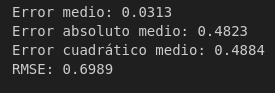

### Interpretación de las métricas de error

---

**Error medio: 0.0313**  
- **¿Qué es?:** Nos representa el promedio de las diferencias entre valores reales y predicciones.  
- **Interpretación:** Un valor cercano (centrado) a cero indica que el modelo no tiene un sesgo sistemático importante. Además en nuestro caso, un valor ligeramente positivo sugiere que el modelo tiende a subestimar levemente los valores reales (predice valores un poco más bajos en promedio).

---

**Error absoluto medio (MAE): 0.4823**  
- **¿Qué es?:** Es el promedio del valor absoluto de los errores.  
- **Interpretación:** En promedio, las predicciones se desvían aproximadamente 0.48 unidades de los valores reales. Esta métrica no considera la dirección del error, solo su magnitud.

---

**Error cuadrático medio (MSE): 0.4884**  
- **¿Qué es?:** Es el promedio de los errores al cuadrado.  
- **Interpretación:** Penaliza más severamente los errores grandes que los pequeños.

---

**RMSE: 0.6989**  
- **¿Qué es?:** Es la raíz cuadrada del MSE, lo que devuelve el error a la escala original de los datos.  
- **Interpretación:** En promedio, nuestras predicciones tienen un error de aproximadamente 0.7 unidades.

---

### Análisis global

- El error medio cercano a cero indica que el modelo no tiene sesgos importantes.  
- La diferencia entre RMSE (0.6989) y MAE (0.4823) sugiere que existen algunos errores grandes que están influyendo en el RMSE.  
- Para evaluar completamente si estos valores representan un buen rendimiento, sería necesario conocer el rango y la escala de los datos originales, así como comparar con modelos más simples (baseline).


